In [1]:
import numpy as np
from typing import Tuple, Dict
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from einops import rearrange, repeat
from ToApps.to_apps import to_slack
import tensorflow as tf
from tensorflow.math import logical_not
from ktfuncs import kt_transformer
from builderfuncs import restore_model, EarlyStopAndSave
from builderfuncs import build_transformer, save_whole_model, restore_model
from parameterdicts import TransformerParameters
import keras_tuner as kt
import os
import datetime


df = pd.read_csv('data/scaled_U2_data.csv', index_col=0)
df.drop("UNNAMED: 0", axis=1, inplace=True)

devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)

print("Num GPUs Available: ", len(devices))

Num GPUs Available:  1


In [42]:
print(list(df.columns)[74])

MW_GROSS


In [2]:
def ttv_split(ds: tf.data.Dataset, ds_size: int, 
              train_split: float = 0.8, 
              val_split: float = 0.1, 
              test_split: float = 0.1) -> Tuple[tf.data.Dataset, 
                                                tf.data.Dataset, 
                                                tf.data.Dataset]:

    assert (train_split + test_split + val_split) == 1
   
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


def mask_window(features: Tuple[Dict[tf.Tensor, tf.Tensor], tf.Tensor], 
                mask: tf.Tensor) -> Tuple[Dict[tf.Tensor, tf.Tensor], 
                                          tf.Tensor]:
    inputs = features[0]
    labels = features[1]
    decoder_labels = tf.einsum('tf,t->tf', labels, mask)
    mask = repeat(mask, 'i -> 1 i j', j=labels.shape[-2])
    mask = tf.math.minimum(mask, rearrange(mask, '1 i j -> 1 j i'))
    decoder_labels.set_shape([12, None])
    mask.set_shape([None, 12, 12])
    inputs.update({'decoder_labels':decoder_labels,
                   'attention_mask':mask})
    return inputs, labels


def split_window(features: tf.Tensor) -> Tuple[Dict[tf.Tensor, tf.Tensor],
                                               tf.Tensor]:
    encoder_input = features[:12, 1:]
    decoder_input = features[11:, 1:75]
    labels = rearrange(features[11:, 0], 'a -> a 1')
    encoder_input.set_shape([12, 247])
    decoder_input.set_shape([12, 74])
    labels.set_shape([12, None])
    

    return {'encoder_inputs':encoder_input, 'decoder_inputs':decoder_input}, labels

                        
def make_dataset(data: pd.DataFrame, length: int, 
                 batch_size: int = 64, multistep: bool = True) -> Tuple[tf.data.Dataset, 
                                                                        tf.data.Dataset, 
                                                                        tf.data.Dataset]:
    data = np.array(data.iloc[:, :], dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(data=data,
                                                        targets=None,
                                                        sequence_length=length,
                                                        sequence_stride=1,
                                                        shuffle=True,
                                                        seed=1,
                                                        batch_size=None)

    ds = ds.filter(lambda x: tf.reduce_all(logical_not(tf.math.is_nan(x))))
    ds = ds.map(split_window)
    if multistep == True:
        nums = np.zeros(170680)
    else:
        nums = np.random.randint(0, length/2-1, 170680)
    mask = tf.sequence_mask(nums, length/2, dtype=tf.float32)
    maskds = tf.data.Dataset.from_tensor_slices(mask)
    ds = tf.data.Dataset.zip((ds, maskds))
    ds = ds.map(mask_window).batch(batch_size)
    ds = ds.apply(tf.data.experimental.assert_cardinality(170680//batch_size + 1))
    train_ds, val_ds, test_ds = ttv_split(ds, 170680//batch_size, train_split=0.8, val_split=0.1, test_split=0.1)
    train_ds = train_ds
    return train_ds, val_ds, test_ds

In [3]:
bs = 64
train_data, val_data, transformer_test_data = make_dataset(df, 23, batch_size=bs)
transformer_test_iter = iter(transformer_test_data)

In [4]:
def ttv_split(ds: tf.data.Dataset, ds_size: int, 
              train_split: float = 0.8, 
              val_split: float = 0.1, 
              test_split: float = 0.1) -> Tuple[tf.data.Dataset, 
                                                tf.data.Dataset, 
                                                tf.data.Dataset]:

    assert (train_split + test_split + val_split) == 1
   
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


def mask_window(features: Tuple[Dict[tf.Tensor, tf.Tensor], tf.Tensor], 
                mask: tf.Tensor) -> Tuple[Dict[tf.Tensor, tf.Tensor], 
                                          tf.Tensor]:
    inputs = features[0]
    labels = features[1]
    decoder_labels = tf.einsum('tf,t->tf', labels, mask)
    mask = repeat(mask, 'i -> 1 i j', j=labels.shape[-2])
    mask = tf.math.minimum(mask, rearrange(mask, '1 i j -> 1 j i'))
    decoder_labels.set_shape([12, None])
    mask.set_shape([None, 12, 12])
    inputs.update({'decoder_labels':decoder_labels,
                   'attention_mask':mask})
    return inputs, labels


def split_window(features: tf.Tensor) -> Tuple[Dict[tf.Tensor, tf.Tensor],
                                               tf.Tensor]:
    encoder_input = features[:12, 1:]
    decoder_input = features[12:, 1:75]
    paddings = tf.constant([[0, 0,], [0, 173]])
    encoder_input = tf.concat([encoder_input, tf.pad(decoder_input, paddings, "CONSTANT")], axis=0)
    labels = rearrange(features[11:, 0], 'a -> a 1')
    decoder_input = features[11:, 1:75]
    encoder_input.set_shape([23, 247])
    decoder_input.set_shape([12, 74])
    labels.set_shape([12, None])
    

    return {'encoder_inputs':encoder_input, 'decoder_inputs':decoder_input}, labels

                        
def make_dataset(data: pd.DataFrame, length: int, 
                 batch_size: int = 64, multistep: bool = True) -> Tuple[tf.data.Dataset, 
                                                                        tf.data.Dataset, 
                                                                        tf.data.Dataset]:
    data = np.array(data.iloc[:, :], dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(data=data,
                                                        targets=None,
                                                        sequence_length=length,
                                                        sequence_stride=1,
                                                        shuffle=True,
                                                        seed=1,
                                                        batch_size=None)

    ds = ds.filter(lambda x: tf.reduce_all(logical_not(tf.math.is_nan(x))))
    ds = ds.map(split_window)
    if multistep == True:
        nums = np.zeros(170680)
    else:
        nums = np.random.randint(0, length/2-1, 170680)
    mask = tf.sequence_mask(nums, length/2, dtype=tf.float32)
    maskds = tf.data.Dataset.from_tensor_slices(mask)
    ds = tf.data.Dataset.zip((ds, maskds))
    ds = ds.map(mask_window).batch(batch_size)
    ds = ds.apply(tf.data.experimental.assert_cardinality(170680//batch_size + 1))
    train_ds, val_ds, test_ds = ttv_split(ds, 170680//batch_size, train_split=0.8, val_split=0.1, test_split=0.1)
    train_ds = train_ds
    return train_ds, val_ds, test_ds

In [5]:
bs = 64
train_data, val_data, park_test_data = make_dataset(df, 23, batch_size=bs)
park_test_iter = iter(transformer_test_data)

In [6]:
transformer = restore_model("model_folder/transformer_folder", modeltype="transformer")
park = restore_model("model_folder/park_folder", modeltype="transformer")

In [22]:

transformer_preds = transformer.predict(transformer_test_data)
park_preds = park.predict(park_test_data)

269/269 [==============================] - 18s 7ms/step


In [8]:
transformer_eval = transformer.evaluate(transformer_test_data)
park_eval = park.evaluate(park_test_data)

269/269 [==============================] - 28s 25ms/step - loss: 0.0098 - mse: 0.0098 - mae: 0.0641 - r2: 0.7994 - explained_variance: 0.8030


In [9]:
print(transformer_eval)
print(park_eval)

[0.0005696180742233992, 0.0005696181324310601, 0.016568496823310852, 0.9872903823852539, 0.987346351146698]
[0.009787644259631634, 0.009787646122276783, 0.06409888714551926, 0.7993772029876709, 0.8029744029045105]


In [10]:
from tabulate import tabulate
table = [transformer_eval[1:], park_eval[1:]]
headers = ["MSE", "MAE", "R2", "Exp. Variance"]
print(tabulate(table, headers=headers))

        MSE        MAE        R2    Exp. Variance
-----------  ---------  --------  ---------------
0.000569618  0.0165685  0.98729          0.987346
0.00978765   0.0640989  0.799377         0.802974


In [85]:
def gradient_importance(seq, model):    
    # seq['encoder_inputs'] = tf.Variable(seq['encoder_inputs'], dtype=tf.float32)
    # seq['decoder_inputs'] = tf.Variable(seq['decoder_inputs'], dtype=tf.float32) 
    # seq['decoder_labels'] = tf.Variable(seq['decoder_labels'], dtype=tf.float32) 
    # seq['attention_mask'] = tf.Variable(seq['attention_mask'], dtype=tf.float32) 
    with tf.GradientTape() as tape:
        tape.watch(seq["decoder_inputs"])
        tape.watch(seq["encoder_inputs"])
        predictions = model(seq)    
    grads = tape.gradient(predictions, seq)
    enc_grads = np.mean(grads["encoder_inputs"], axis=0)
    dec_grads = np.mean(grads["decoder_inputs"], axis=0)
    return enc_grads, dec_grads

In [71]:
data = next(iter(transformer_test_data))
inputs = data[0]
labels = data[1]



In [87]:
enc_grads, dec_grads = gradient_importance(inputs, transformer)
print(np.mean(np.abs(enc_grads)))
print(np.mean(np.abs(dec_grads)))

0.015468998
0.052529726


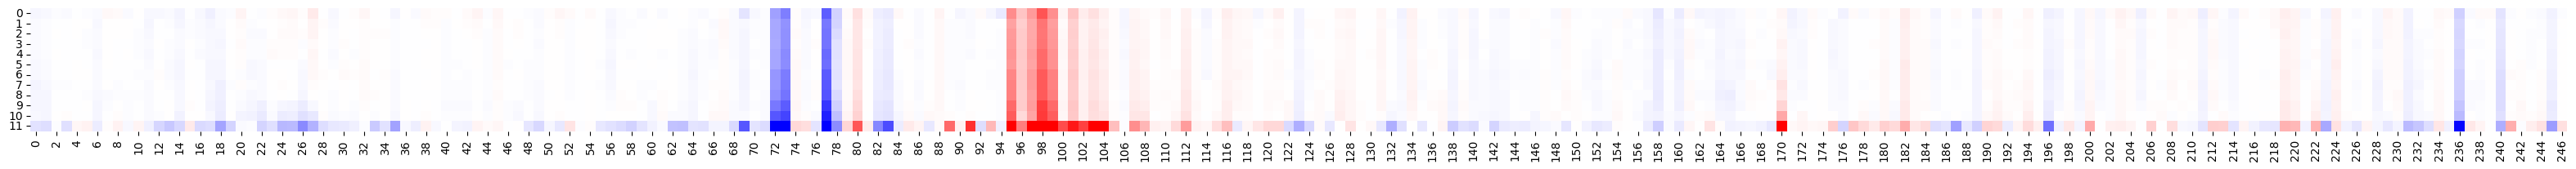

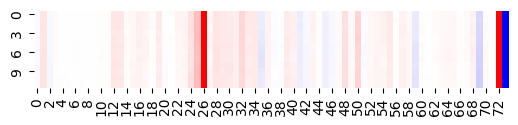

In [99]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(40,40)) 
sns.heatmap(np.array(enc_grads), cmap="bwr", vmin=-.3, vmax=0.3, center=0, square=True, cbar=False, ax=ax)
plt.show()
fig, ax = plt.subplots(figsize=(10,1)) 
sns.heatmap(np.array(dec_grads), cmap="bwr", vmin=-.3, vmax=0.3, center=0, square=True, cbar=False, ax=ax)
plt.show()


In [1]:
print(list(df.columns)[27])

NameError: name 'df' is not defined